In [7]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import *

'----------------------------------------------------------------------------------------------------------------------'
'''
With the following code we can solve the reaction-diffusion equation system put forward by Sherratt
in his paper 'Ecological chaos in the wake of invasion' from 1993 (doi: 10.1073/pnas.92.7.2524).
Additionally, one can make use of this code to produce supplementary results that were not considered in the paper.
'''
'----------------------------------------------------------------------------------------------------------------------'


def fp(p, h, A, B, C, K, m, model=1):
    """
    :param p: predator population size
    :param h: prey population size
    :param A: model parameter
    :param B: model parameter
    :param C: model parameter
    :param model: 1 for equation 2 and 2 for equation 3 from Sherrats paper.
        3 for Rosenzweig Macarthur model with Holling type 2 functional response
    :return: Predator reaction term
    """
    predator_model = {1: B * p * (1 - p / h),
                      2: B * p * (A - 1 - A * np.exp(-C * h)),
                      3: B * h / (C + h) * p - m * p}
    return predator_model.get(model, "Invalid model")


def fh(p, h, A, B, C, K, m, model=1):
    """
    Prey reaction term
    see function fp
    """
    prey_model = {1: h * (1 - h) - A * h * p / (h + C),
                  2: h * (1 - h) - p * (1 - np.exp(-C * h)),
                  3: A * h * (1 - h / K) - B * h / (C + h) * p}
    return prey_model.get(model, "Invalid model")


def differential_equation_systems(t, x, A, B, C, K=1, m=1, model=1):
    """
    Predator-prey system without diffusion
    """
    p, h = x
    return [fp(p, h, A, B, C, K, m, model), fh(p, h, A, B, C, K, m, model)]


def predator_prey_model(y, t, A, B, C, K, m, model, Dp, Dh, dx):
    """
    Predator-prey model with diffusion
    The ODEs are derived using the method of lines.
    See https://docs.scipy.org/doc/scipy/reference/tutorial/integrate.html#solving-a-system-with-a-banded-jacobian-matrix
    """

    # The vectors u and v are interleaved in y.  We define views of u and v by slicing y.
    u = y[::2]
    v = y[1::2]
    dydt = np.empty_like(y)
    dudt = dydt[::2]
    dvdt = dydt[1::2]

    # Compute du/dt and dv/dt.  The end points and the interior points are handled separately.
    dudt[0] = fp(u[0], v[0], A, B, C, K, m, model) + Dp * (-2.0 * u[0] + 2.0 * u[1]) / dx ** 2
    dudt[1:-1] = fp(u[1:-1], v[1:-1], A, B, C, K, m, model) + Dp * np.diff(u, 2) / dx ** 2
    dudt[-1] = fp(u[-1], v[-1], A, B, C, K, m, model) + Dp * (- 2.0 * u[-1] + 2.0 * u[-2]) / dx ** 2
    dvdt[0] = fh(u[0], v[0], A, B, C, K, m, model) + Dh * (-2.0 * v[0] + 2.0 * v[1]) / dx ** 2
    dvdt[1:-1] = fh(u[1:-1], v[1:-1], A, B, C, K, m, model) + Dh * np.diff(v, 2) / dx ** 2
    dvdt[-1] = fh(u[-1], v[-1], A, B, C, K, m, model) + Dh * (-2.0 * v[-1] + 2.0 * v[-2]) / dx ** 2

    return dydt


def initialize_populations(xMax=1100, dx=0.1, initial_prey=None, invasion_location=0, invasion_size=0.1):
    """
    :param xMax: Spatial boundary
    :param dx: Spatial step size
    :param initial_prey: Value to which the prey population is set in the beginning. If no value is given, we draw the
    prey density from uniform distribution from 0 to 1 for each x.
    :param invasion_location: Where the predator invades
    :param invasion_size: Predator population size at the beginning
    :return: the initial states,y0. Prey and predator states alternate starting with the predator.
    """
    pred_init = np.zeros(int(xMax / dx))
    pred_init[int(invasion_location * xMax / dx)] = invasion_size
    if initial_prey:
        prey_init = np.full(int(xMax / dx), initial_prey)
    else:
        prey_init = np.random.random(int(xMax / dx))
    y0 = np.zeros(2 * int(xMax / dx))
    y0[::2] = pred_init
    y0[1::2] = prey_init
    return y0


def plot_spatial_dynamics(t, dt, A, B, C, model, Dp, Dh, xMax, dx, K=1, m=1, plotPredator=False, saveFig=False):
    """
    Plots the spatial dynamics for a given t
    @param t: time for which the spatial dynamics should be plotted
    @param dt: time step size
    @param A: model parameter
    @param B: model parameter
    @param C: model parameter
    @param model: which model should be used
    @param Dp: predator diffusion coefficient
    @param Dh: prey diffusion coefficient
    @param xMax: spatial boundary
    @param dx: spatial step size
    @param K: parameter for RM-model
    @param m: parameter for RM-model
    @param plotPredator: if the predator dynamics should be plotted
    @param saveFig: if the figure should be saved in the current directory
    """

    print("Plotting spatial dynamics...", end="")
    tmin = 0
    ts = np.linspace(tmin, t, int((t - tmin) / dt))
    xs = np.linspace(0, xMax, int(xMax / dx))
    y0 = initialize_populations(xMax, dx)
    results = odeint(predator_prey_model, y0, ts, args=(A, B, C, K, m, model, Dp, Dh, dx), ml=2, mu=2)
    plt.figure(dpi=150, figsize=[7, 4.2])
    if t < 1:
        plt.plot(xs, y0[1::2], color="green")
    else:
        plt.plot(xs, results[int((t - tmin) / dt) - 1][1::2], color="green", label="Prey")
    plt.xlim(0, xMax)
    plt.xlabel("$x$", fontsize=12)
    plt.ylabel("Prey", fontsize=12)
    plt.ylim(-0.1, 1.1)
    plt.title("$t = $" + str(t), fontsize=14)
    if saveFig:
        plt.savefig("spatial_prey_t" + str(t))
    plt.show()
    if plotPredator:
        plt.figure(dpi=150, figsize=[7, 4.2])
        if t < 1:
            plt.plot(xs, y0[::2], color="green")
        else:
            plt.plot(xs, results[int((t - tmin) / dt) - 1][::2], color="crimson", label="Predator")
        plt.xlim(0, xMax)
        plt.xlabel("$x$", fontsize=12)
        plt.ylabel("Predator", fontsize=12)
        plt.ylim(-0.04, 0.9)
        plt.title("$t = $" + str(t), fontsize=14)
        if saveFig:
            plt.savefig("spatial_predator_t" + str(t))
        plt.show()
    print("\rPlotting spatial dynamics... done")


def plot_temporal_dynamics(x, dx, A, B, C, model, Dp, Dh, tMax, dt, K=1, m=1, plotPredator=False, saveFig=False):
    """
    Plots the spatial dynamics for a given x
    @param x: location for which the temporal dynamics should be plotted
    @param dx: space step size
    @param A: model parameter
    @param B: model parameter
    @param C: model parameter
    @param model: which model should be used
    @param Dp: predator diffusion coefficient
    @param Dh: prey diffusion coefficient
    @param tMax: temporal boundary
    @param dt: time step size
    @param K: parameter for RM-model
    @param m: parameter for RM-model
    @param plotPredator: if the predator dynamics should be plotted
    @param saveFig: if the figure should be saved in the current directory
    """

    print("Plotting temporal dynamics...", end="")
    ts = np.linspace(0, tMax, int(tMax / dt))
    y0 = initialize_populations(x, dx)
    results = odeint(predator_prey_model, y0, ts, args=(A, B, C, K, m, model, Dp, Dh, dx), ml=2, mu=2)
    prey_results = [item[1::2] for item in results]
    prey_results_at_x = [item[-1] for item in prey_results]
    plt.figure(dpi=150)
    plt.plot(ts, prey_results_at_x, color="green")
    plt.xlim(10, tMax)
    plt.xlabel("$t$", fontsize=12)
    plt.ylabel("Prey", fontsize=12)
    plt.title("$x = $" + str(x), fontsize=14)
    plt.show()
    if saveFig:
        plt.savefig("temporal_prey_t" + str(t))
    if plotPredator:
        plt.figure(dpi=150)
        plt.plot(ts, results[::2][int(x / 2)], color="crimson")
        plt.xlim(0, xMax)
        plt.xlabel("$x$", fontsize=12)
        plt.ylabel("Predator", fontsize=12)
        plt.title("$t = $" + str(tMax), fontsize=14)
        plt.show()
        if saveFig:
            plt.savefig("temporal_predator_t" + str(t))
    print("\rPlotting temporal dynamics... done")


def plot_state_space(t, dt, A, B, C, model, Dp, Dh, xMax, dx, K=1, m=1, saveFig=False):
    """
    Plots state space of the predator (x-axis) and prey (y-axis) for a given t for x=0 to x=xMax.
    See other methods for documentation
    """

    print("Plotting state space...", end="")
    tmin = 0
    ts = np.linspace(tmin, t, int((t - tmin) / dt))
    y0 = initialize_populations(xMax, dx)
    results = odeint(predator_prey_model, y0, ts, args=(A, B, C, K, m, model, Dp, Dh, dx), ml=2, mu=2)
    plt.figure(dpi=150, figsize=[7, 4.2])
    plt.plot(results[int((t - tmin) / dt) - 1][1::2], results[int((t - tmin) / dt) - 1][::2], 'k.')
    plt.ylabel("Predator", fontsize=13)
    plt.xlabel("Prey", fontsize=13)
    plt.title("$t = $" + str(t) + ", $x_{max} = $" + str(xMax))
    if saveFig:
        plt.savefig("state_space_t_" + str(t))
    plt.show()
    print("\rPlotting state space... done")


def plot_3D(A, B, C, model, Dp, Dh, tMax, xMax, dx, dt, K=1, m=1, tMin=0, xMin=0, nAngles=3):
    """
    Plots the prey population size in dependence of time and space from nAngles different angles.
    See other methods for documentation.
    """

    print("Creating 3D plot...", end="")
    ts = np.linspace(tMin, tMax, int(tMax / dt))
    xs = np.linspace(xMin, xMax, int((xMax - xMin) / dx))
    y0 = initialize_populations(xMax, dx)
    results = odeint(predator_prey_model, y0, ts, args=(A, B, C, K, m, model, Dp, Dh, dx), ml=2, mu=2)
    prey_results = np.array([item[1::2] for item in results])

    azims = np.arange(0, 370, 370 / nAngles)  # different angles
    for azim in azims:
        hf = plt.figure(dpi=150, figsize=[9, 6.8])
        ha = hf.add_subplot(111, projection='3d')
        X, Y = np.meshgrid(ts, xs)
        ha.plot_surface(Y.T, X.T, prey_results, color="violet")
        ha.set_xlabel("$x$", fontsize=14)
        ha.set_ylabel("$t$", fontsize=14)
        ha.set_zlabel("Prey population", fontsize=14)
        ha.dist = 10
        ha.elev = 40
        ha.azim = azim
    print("\rCreating 3D plot... done")


def plot_time_series(A, B, C, model, K=1, m=1, dt=0.05, p0=0.5, h0=0.5, tMin=0, tMax=250, saveFig=False):
    """
    Simulates and plots the time series of the predator and prey without diffusion with initial conditions [p0, h0].
    See other methods for documentation.
    """

    print("Plotting time series without diffusion...", end="")
    results = solve_ivp(differential_equation_systems, (tMin, tMax), [p0, h0], args=[A, B, C, K, m, model], max_step=dt)
    plt.figure(dpi=140)
    plt.plot(results.t, results.y[0], linewidth=2, color="crimson")
    plt.xlabel("Time, $t$", fontsize=13)
    plt.ylabel("Predator concentration", fontsize=13)
    plt.show()
    if saveFig:
        plt.savefig("predator_timeSeries")
    plt.figure(dpi=140)
    plt.plot(results.t, results.y[1], linewidth=2, color="green")
    plt.xlabel("Time, $t$", fontsize=13)
    plt.ylabel("Prey concentration", fontsize=13)
    plt.show()
    if saveFig:
        plt.savefig("prey_timeSeries")
    print("\rPlotting time series without diffusion... done")


'----------------------------------------------------------------------------------------------------------------------'
# Demo:

dx = 0.12
dt = 0.12
A = 1.5
B = 1
C = 5
K = 1
m = 0.05
Dp = 1
Dh = 1
model = 2

Plotting time series without diffusion... done


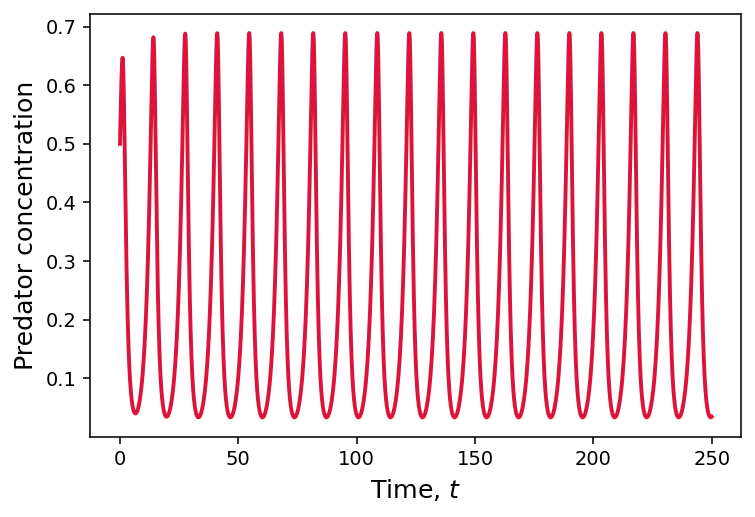

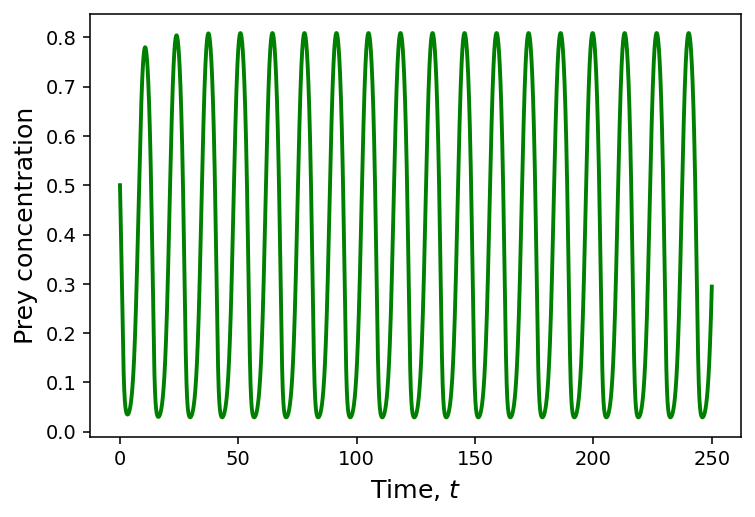

In [8]:
tMax = 1000
plot_time_series(A, B, C, model, K=K, m=m)

Plotting spatial dynamics... done


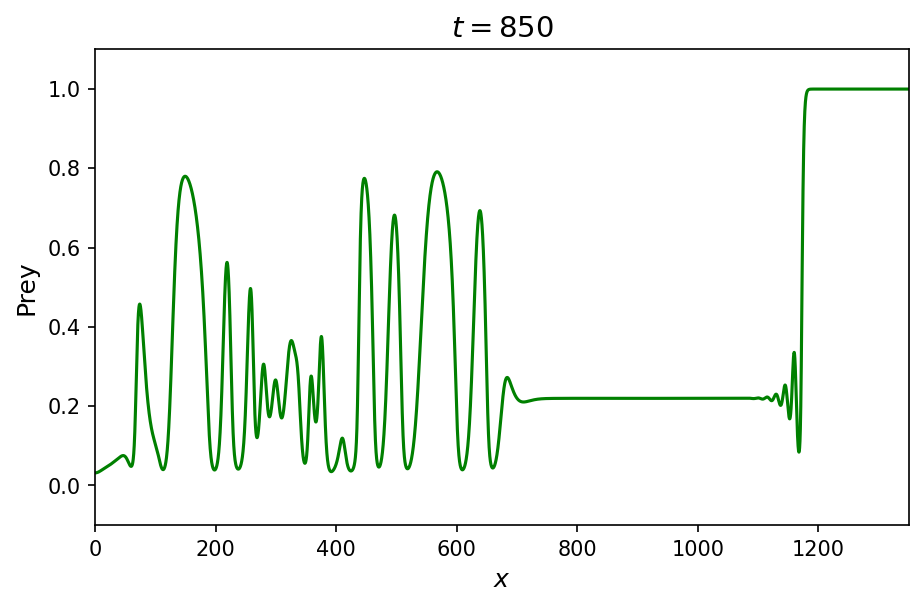

In [9]:
t = 850
xMax = 1350
plot_spatial_dynamics(t, dt, A, B, C, model, Dp, Dh, xMax, dx, K=K, m=m)

Plotting temporal dynamics... done


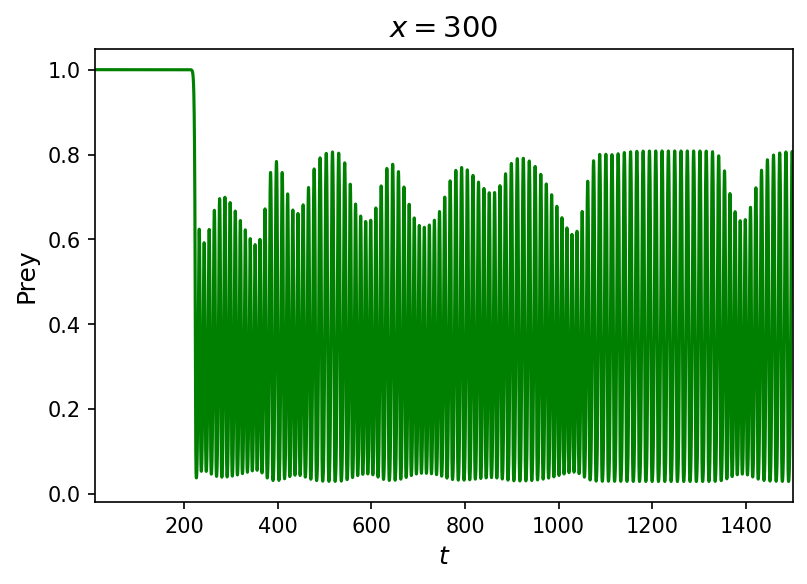

In [10]:
x = 300
tmax = 1500
plot_temporal_dynamics(x, dx, A, B, C, model, Dp, Dh, tmax, dt, K=K, m=m)

Plotting state space... done


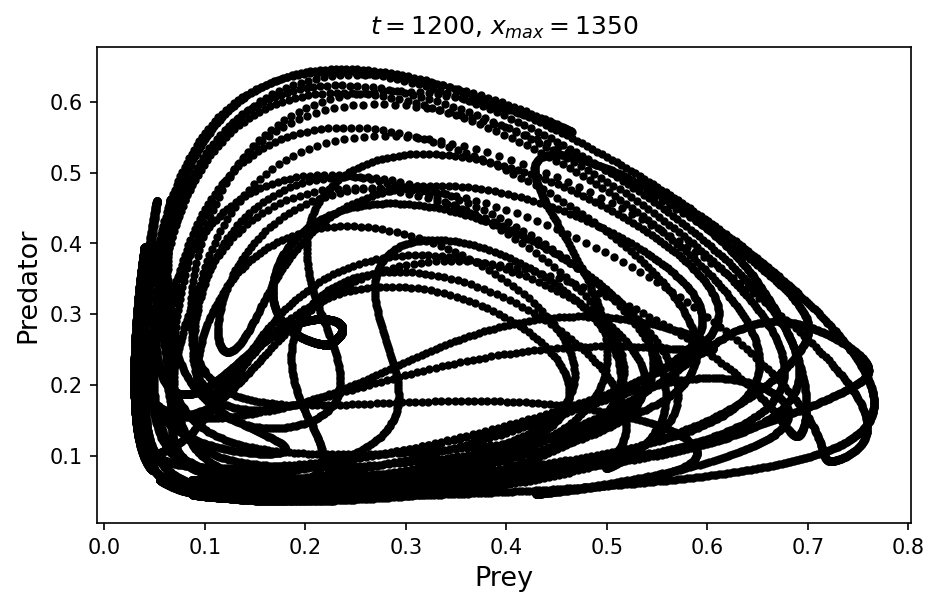

In [11]:
t = 1200
plot_state_space(t, dt, A, B, C, model, Dp, Dh, xMax, dx, )

Creating 3D plot... done


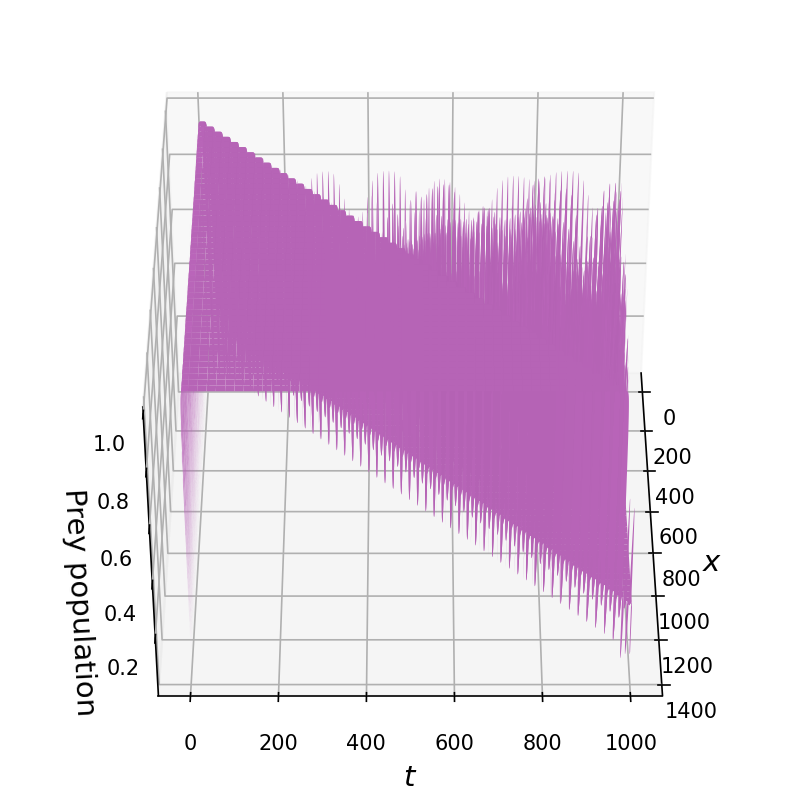

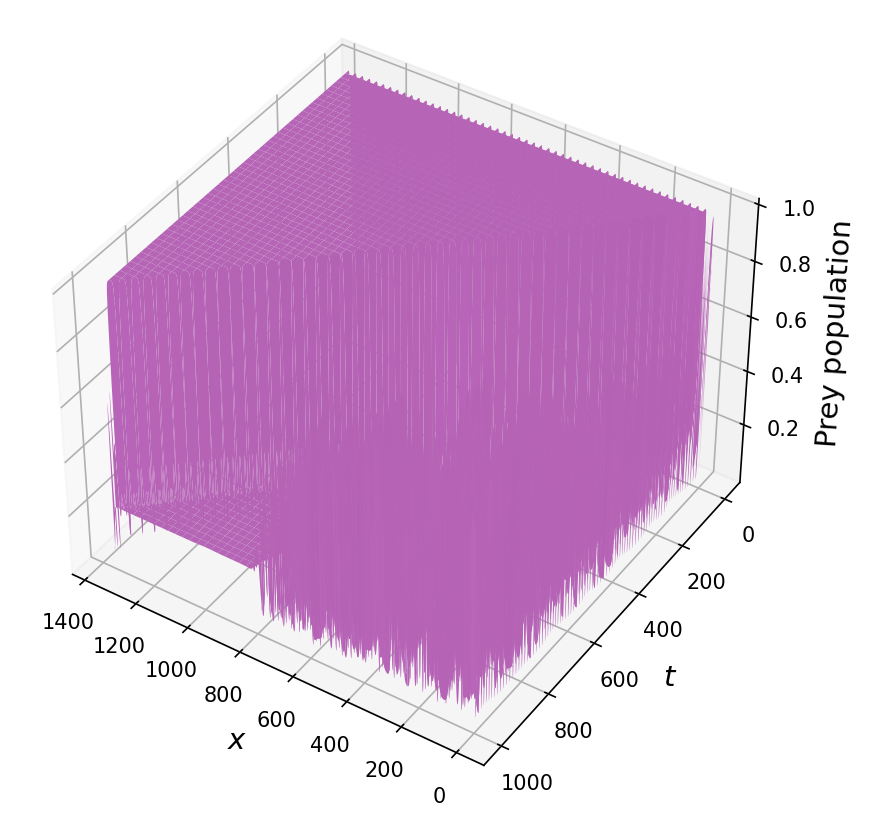

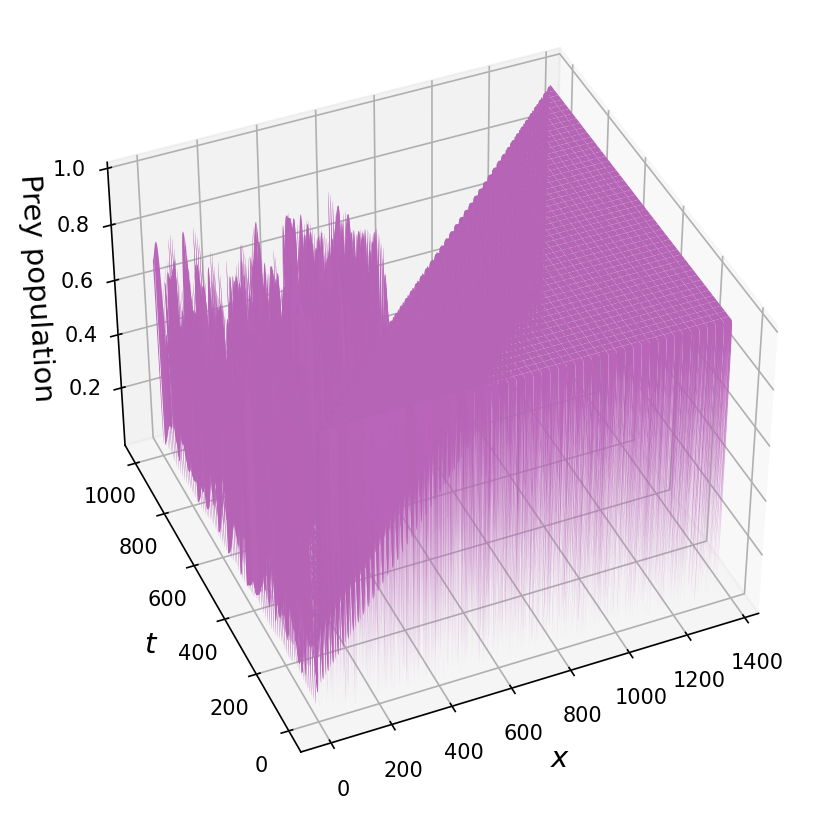

In [12]:
plot_3D(A, B, C, model, Dp, Dh, tMax, xMax, dx, dt, K=K, m=m)